In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
font = {'family' : 'Helvetica',
        'size'   : 7}
mpl.rc('font', **font)

In [2]:
# More data is collected than is used. Only 2361 rounds needed.
with open("validation/experiment_output.txt", "r") as file:
    lines = file.readlines()


times = []
TMs = []
recv_times = []
failed = []
bitstrings = []
for i, line in tqdm(enumerate(lines)):
    if i >= 23651:
        break
    line = line.lstrip()
    if len(line) == 0:
        continue
    circuit_stream = line.split(" ")
    if len(circuit_stream) != 13:
        failed.append(i)
        # print(f'Round {i} failed timing requirement with repeated trial.')
        continue
    trial_id = int(circuit_stream[0].split(":")[0][1:])
    leakage = circuit_stream[-1].split(":")[1]
    recv_time = int(circuit_stream[-1].split(":")[2][:-1])
    recv_times.append(recv_time)
    circuit_stream = line.split(" ")
    gate_layers = circuit_stream[:-3]
    bitstring = circuit_stream[-2].split(":")[1][1:]
    bitstrings.append(bin(int(bitstring)))
    meas = circuit_stream[-3].split(":")[1][1:]
    meas_time = recv_time - int(circuit_stream[-3].split(":")[2])
    if meas_time > 39*10**6:
        failed.append(i)
        # print(f'Round {i} failed timing requirement with measurement time {meas_time/10**6}.')
        continue
    sq_gates_list = [gate_layer.split(":")[2] for gate_layer in gate_layers]
    layer_to_result_times = [recv_time - int(gate_layer.split(":")[3]) for gate_layer in gate_layers]
    times.append([meas_time] + layer_to_result_times[::-1])
    TMs.append(meas_time)
    
times = 10**-6*np.array(times).T

23651it [00:00, 114999.36it/s]


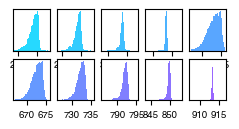

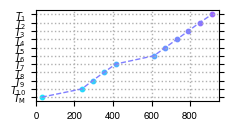

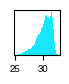

In [3]:
mm = 1/25.4  # centimeters in inches
fig, axs = plt.subplots(2, 5, figsize=(70 * mm, 30 * mm))
means = []
for i in range(11):
    time_mean = np.mean(times[i])
    means.append(time_mean)
    if i == 0:
        continue
    j = i - 1
    axs[j//5, j%5].hist(times[i], bins=np.arange(time_mean - 5, time_mean + 4, 0.2), color=cm.cool(0.1 + i / 20))
    axs[j//5, j%5].tick_params(axis='y', left=False, labelleft=False)
# plt.savefig('timing_distribution.pdf')
plt.show()

fig1, ax1 = plt.subplots(figsize=(60 * mm, 30 * mm))
ax1.plot(means, np.arange(11), '--', linewidth=1, color=cm.cool(0.5))
for i, time_mean in enumerate(means):
    ax1.scatter(time_mean, i, s=10, color=cm.cool(0.1 + i / 20))
ax1.grid(which='major', linestyle=':', linewidth=1)
ax1.set_yticks(range(11), [r'$T_{\rm M}$'] + ['$T_{' + str(i) + '}$' for i in range(10, 0, -1)])
ax1.tick_params(axis='y', left=True, right=True)
ax1.set_xlim(0, 950)
# plt.savefig('timing.pdf')
plt.show()

fig1, ax1 = plt.subplots(figsize=(15 * mm, 15 * mm))
ax1.hist(times[0], bins=np.arange(means[0] - 5, means[0] + 2.5, 0.2), color=cm.cool(0.1));
ax1.tick_params(axis='y', left=False, labelleft=False)
# plt.savefig('TM_distribution.pdf')
plt.show()